# Linear Model

The linear method makes use of the log backward return (log price difference) to predict foward return.

Training:
1) Ridge regression: on 30 features
2) PC regression: pca on 30 features then perform ols

Feature: 10 stocks, each with 3 backward return (say, 3min, 7min, 10min, see correlation to decide)

Response: 10 stocks' 30min forward return. 

Groups: [1,3,5,9],[2,4,7],[0],[3],[9]

## Data Preparation

In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

In [176]:
def wide_format(df):
    df_= df.reset_index(level=['stock']).sort_index()
    df_ = df_.pivot(columns ='stock')
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_


def get_feature_train(log_pr, volu, x_begin_idx, x_end_idx, y_begin_idx, 
                        grp_idx=None, rm_outlier=False, print_cor=True):
    """
    Input:
    log_pr (pdSeries): train set
    volu (pdSeries): train set
    x_begin_idx (pdIndex): to truncate the NaNs
    grp_idx (dict): key is group idx, value is list of stock idx

    Returns:
    feature_dict (dict): key is group idx, value is a tuple of feature matrix and response
    """

    log_pr_df = log_pr.reset_index().melt(id_vars=['timestamp'])
    log_pr_df.columns = ['timestamp', 'stock', 'log_pr']
    log_pr_df = log_pr_df.set_index(['timestamp', 'stock']).sort_index()

    volu_df = volu.reset_index().melt(id_vars=['timestamp'])
    volu_df.columns = ['timestamp', 'stock', 'volu']
    volu_df = volu_df.set_index(['timestamp', 'stock']).sort_index()

    features = pd.DataFrame(index=log_pr_df.index)
    # log_pr feature
    for i in [10, 20, 30]:
        features['log_pr_{}'.format(i)] = -log_pr_df.groupby(level='stock').log_pr.diff(i)

    std_10 = lambda x: x.rolling(10).std()
    features['log_pr_std_10'] = log_pr_df.groupby(level='stock').log_pr.apply(std_10)

    # volume feature
    log_fn = lambda x: np.log(x+1)
    features['log_volu'] = volu_df.groupby(level='stock').volu.apply(log_fn)

    # stdised volume in 2 hours backward rolling windows
    zscore_fn = lambda x: (x - x.rolling(window=240, min_periods=20).mean()) / x.rolling(window=240, min_periods=20).std()
    features['volu_z_score'] = volu_df.groupby(level='stock').volu.apply(zscore_fn)

    # feature_dropped = features.iloc[x_begin_idx:x_end_idx]
    response = log_pr.diff(30)

    if grp_idx is not None:
        feature_dict = {}
        for key, idx_lis in grp_idx.items():
            feature_df_dropped = wide_format(features.loc[pd.IndexSlice[:,idx_lis],:])
            # transform back to wide format
            feature_dict[key] = (feature_df_dropped.iloc[x_begin_idx:x_end_idx], 
                                            response[idx_lis].iloc[y_begin_idx:])
        return feature_dict
    else:
        # transform back to wide format
        feature_df_dropped = wide_format(features).iloc[x_begin_idx:x_end_idx]
        # feature_df_dropped = feature_df[x_begin_idx:x_end_idx]
    
        if print_cor:
            for i in range(10):
                feature_train_0 = features.xs(i, level='stock')
                print(feature_train_0.corrwith(response[i]))

        return feature_df_dropped, response.iloc[y_begin_idx:]

In [175]:
grp_idx = {0:[1,5,6,8], 1:[0,2,3,4,7,9]}

x_begin_idx = 30
x_end_idx = -30
y_begin_idx = 60

train_split_t = log_pr.index[-87841]
vali_split_t = log_pr.index[-44641]

train_feature_dict = get_feature_train(log_pr[:train_split_t], volu[:train_split_t], x_begin_idx, x_end_idx, y_begin_idx,
                                        grp_idx=grp_idx, print_cor=False)

vali_feature_dict = get_feature_train(log_pr[train_split_t:], volu[train_split_t:], x_begin_idx, x_end_idx, y_begin_idx,
                                        grp_idx=grp_idx,print_cor=False)

### Modelling

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

#### Train Ridge Model 1

In [153]:
xtrain0, ytrain0 = train_feature_dict[0]
xvali0, yvali0 = vali_feature_dict[0]

In [154]:
alpha_grid = np.logspace(-4, 1, 15)
n = ytrain0.shape[1]
mse = []
for i in range(len(alpha_grid)):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain0, ytrain0)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali0),columns={i for i in range(n)},index=yvali0.index)
    mse.append(mean_squared_error(yvali0, yvali_hat_ridge_a))

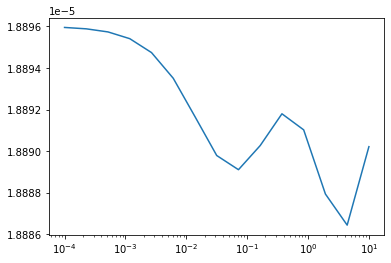

In [155]:
plt.plot(alpha_grid, mse)
plt.xscale('log')

In [156]:
min_idx = np.argmin(mse)
min_alpha = alpha_grid[min_idx]
print(min_alpha)

4.393970560760795


In [157]:
rr0 = Ridge(alpha=min_alpha).fit(pd.concat((xtrain0, xvali0)), pd.concat((ytrain0, yvali0)))

#### Train Ridge model 2

In [158]:
xtrain1, ytrain1 = train_feature_dict[1]
xvali1, yvali1 = vali_feature_dict[1]

In [159]:
alpha_grid = np.logspace(-4, 1, 15)
n = ytrain1.shape[1]
mse = []
for i in range(len(alpha_grid)):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain1, ytrain1)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali1), columns={i for i in range(n)}, index=yvali1.index)
    mse.append(mean_squared_error(yvali1, yvali_hat_ridge_a))

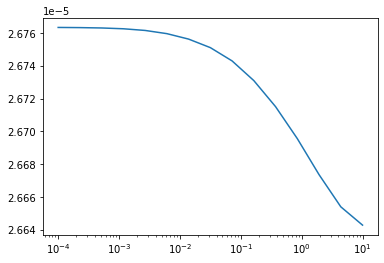

In [160]:
plt.plot(alpha_grid, mse)
plt.xscale('log')

In [161]:
min_idx = np.argmin(mse)
min_alpha = alpha_grid[min_idx]
print(min_alpha)

10.0


In [162]:
rr1 = Ridge(alpha=min_alpha).fit(pd.concat((xtrain1, xvali1)),pd.concat((ytrain1, yvali1)))

In [177]:
rr1

Ridge(alpha=10.0)

#### Save Model

In [178]:
rr0

Ridge(alpha=4.393970560760795)

In [179]:
# import pickle
# pickle.dump(rr0, open('ridge0.sav', 'wb'))
# pickle.dump(rr1, open('ridge1.sav', 'wb'))

In [180]:
import pickle
with open("models.pckl", "wb") as f:
    for model in [rr0, rr1]:
        pickle.dump(model, f)

### Evaluation

In [166]:
def wide_format_test(df):
    df_= df.reset_index()
    df_ = df_.pivot(columns ='index').apply(lambda s: s.dropna().reset_index(drop=True))
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_

def get_feature_test(log_pr, volu, grp_idx=None):
    """
    Input: 
    log_pr (pdSeries): 1 day of log pr 
    volu (pdSeries): 1 day of volume

    Output:
    test data frame
    """
    features = pd.DataFrame(index=log_pr.columns)

    # backward return
    # print(-(log_pr.iloc[-1] - log_pr.iloc[-30]).values)
    for i in [10, 20, 30]:
        features['log_pr_{}'.format(i)] = -(log_pr.iloc[-1] - log_pr.iloc[-i]).values
    # backward rolling std
    features['log_pr_std_10'] = log_pr.iloc[-10:].std(0).values
    
    # volume features
    features['log_volu'] = np.log(volu.iloc[-1].values + 1)
    features['volu_z_score'] = ((volu.iloc[-1] - volu.iloc[-240:].mean())/volu.iloc[-240:].std()).values

    if grp_idx is None:
        return wide_format_test(features)
    else:
        df_dict = {}
        for key, idx_lis in grp_idx.items():
            df_dict[key] = wide_format_test(features.loc[idx_lis])
        return df_dict


In [167]:
model_dict = {i: pickle.load(open('../model/ridge{}.sav'.format(i), 'rb')) for i in range(2)}

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    grp_idx = {0:[1,5,6,8], 1:[0,2,3,4,7,9]}
    x = get_feature_test(A, B, grp_idx=grp_idx)
    pred_dict = {i: model.predict(x[i]) for i, model in model_dict.items()}
    
    out = np.zeros(10)
    for keys, idx in grp_idx.items():
        out[idx] = pred_dict.get(keys)

    return out

In [168]:
# def get_r_hat_tune(A, B):
#     # grp_idx = {0:[1,5,6,8], 1:[0,2,3,4,7,9]}
#     x = get_feature_test(A, B)
#     return rr.predict(x)

In [169]:
def evaluate_tune(log_pr_test, volu_test):

    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    # r_fwd = return_true.iloc[1440::10]
    # r_fwd.index = log_pr_test.index[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=log_pr_test.columns, dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t], volu_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat), np.corrcoef(r_fwd_all, r_hat_all)[0,1]

In [171]:
log_pr_test = log_pr
volu_test = volu

In [172]:
evaluate_tune(log_pr_test, volu_test)

Time used:  222.40197610855103


(0    0.056759
 1    0.076502
 2    0.053963
 3    0.056852
 4    0.126005
 5    0.074002
 6    0.079662
 7    0.041148
 8    0.110821
 9    0.090038
 dtype: float64,
 0.07260984465426996)

In [173]:
log_pr_train_vali = log_pr[:train_split_t]
volu_train_vali = volu[:train_split_t]

In [174]:
evaluate_tune(log_pr_train_vali, volu_train_vali)

Time used:  146.94605422019958


(0    0.043323
 1    0.060267
 2    0.048021
 3    0.065409
 4    0.124495
 5    0.073912
 6    0.090818
 7    0.045182
 8    0.106579
 9    0.076561
 dtype: float64,
 0.0659273964246186)